# Определение перспективного тарифа для телеком-компании


Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
 * Тариф «Смарт»
   * Ежемесячная плата: 550 рублей
   * Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
   * Стоимость услуг сверх тарифного пакета:
     * минута разговора: 3 рубля
     * сообщение: 3 рубля
     * 1 Гб интернет-трафика: 200 рублей
 * Тариф «Ультра»
   * Ежемесячная плата: 1950 рублей
   * Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
   * Стоимость услуг сверх тарифного пакета:
     * минута разговора: 1 рубль
     * сообщение: 1 рубль
     * 1 Гб интернет-трафика: 150 рублей
     
     
     
Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Цель исследования:**
 * Проверьте гипотезы
   * средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
   * средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Ход исследования**

 * Обзор данных.
 * Предобработка данных.
 * Анализ данных
 * Проверка гипотез

## Обзор данных

Составим первое представление о данных с помощью средств pandas. Так же в ходе работы нам потребуются средства библиотек matplotlib и seaborn, numpy, scipy. 

In [2]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib as plt
import numpy as np
from scipy import stats as st

Выгрузим данные в csv-файлы.

### Таблица users

In [3]:
# чтение файла с данными и сохранение в users
users = pd.read_csv('/datasets/users.csv')

Посмотрим первые 10 строк таблицы

In [4]:
# получение первых 10 строк таблицы users
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Продолжим изучать данные. Теперь посмотрим общую информацию о таблице.

In [5]:
# получение общей информации о данных в таблице users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Получим больше информации при помощи метода describe(), посмотрим на разброс значений по столбцам

In [6]:
# получение разброса значений методом describe()
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Опишем, что известно об этой таблице, что необходимо будет учесть при предобработке данных


Таблица users (информация о пользователях):
 * user_id — уникальный идентификатор пользователя
 * first_name — имя пользователя
 * last_name — фамилия пользователя
 * age — возраст пользователя (годы)
 * reg_date — дата подключения тарифа (день, месяц, год)
 * churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
 * city — город проживания пользователя
 * tarif — название тарифного плана

Пропуски:
 * Есть только в колонке churn_date, где они логически обоснованы (тариф ещё действовал на момент выгрузки данных)

Типы данных:
 * user_id - приведём в строку, чтобы не считать по этому параметру числовые характеристики
 * churn_date - приведём к datetime
 * reg_date - приведём к datetime
 * tariff - приведём к "category", чтобы pandas воспринимал его не как строку, а как категорию

### Таблица calls

In [7]:
# чтение файла с данными и сохранение в calls
calls = pd.read_csv('/datasets/calls.csv')

Посмотрим первые 10 строк таблицы

In [8]:
# получение первых 10 строк таблицы calls
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Продолжим изучать данные. Теперь посмотрим общую информацию о таблице.

In [9]:
# получение общей информации о данных в таблице calls
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Получим больше информации при помощи метода describe(), посмотрим на разброс значений по столбцам

In [10]:
# получение разброса значений методом describe()
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Опишем, что известно об этой таблице, что необходимо будет учесть при предобработке данных


Таблица calls (информация о звонках):
 * id — уникальный номер звонка
 * call_date — дата звонка
 * duration — длительность звонка в минутах
 * user_id — идентификатор пользователя, сделавшего звонок

Пропуски: 
 * Нет

Типы данных:
 * user_id переведём в строку, чтобы не считать по этому параметру числовые характеристики
 * call_date - приведём к datetime

### Таблица messages

In [11]:
# чтение файла с данными и сохранение в messages
messages = pd.read_csv('/datasets/messages.csv')

Посмотрим первые 10 строк таблицы

In [12]:
# получение первых 10 строк таблицы messages
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Продолжим изучать данные. Теперь посмотрим общую информацию о таблице.

In [13]:
# получение общей информации о данных в таблице messages
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Опишем, что известно об этой таблице, что необходимо будет учесть при предобработке данных


Таблица messages (информация о сообщениях):
 * id — уникальный номер сообщения
 * message_date — дата сообщения
 * user_id — идентификатор пользователя, отправившего сообщение

Пропуски:
 * Нет

Типы данных:
 * user_id переведём в строку, чтобы не считать по этому параметру числовые характеристики
 * id переведём в строку, чтобы не считать по этому параметру числовые характеристики
 * message_date - приведём к datetime

### Таблица internet

In [14]:
# чтение файла с данными и сохранение в internet
internet = pd.read_csv('/datasets/internet.csv')

Посмотрим первые 10 строк таблицы

In [15]:
# получение первых 10 строк таблицы internet
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Продолжим изучать данные. Теперь посмотрим общую информацию о таблице.

In [16]:
# получение общей информации о данных в таблице internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Получим больше информации при помощи метода describe(), посмотрим на разброс значений по столбцам

In [17]:
# получение разброса значений методом describe()
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Опишем, что известно об этой таблице, что необходимо будет учесть при предобработке данных


Таблица internet (информация об интернет-сессиях):
 * id — уникальный номер сессии
 * mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 * session_date — дата интернет-сессии
 * user_id — идентификатор пользователя

Пропуски:
 * Нет
 
Типы данных:
 * user_id переведём в строку, чтобы не считать по этому параметру числовые характеристики
 * session_date - приведём к datetime
 
Другое:
 * Cтолбец Unnamed: 0, кажется, что просто дублирует id. Проверим эту гипотезу и удалим столбец, если она подтвердится

### Таблица tariffs

In [18]:
# чтение файла с данными и сохранение в tariffs
tariffs = pd.read_csv('/datasets/tariffs.csv')

Посмотрим на таблицу

In [19]:
# получение первых 10 строк таблицы tariffs
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Продолжим изучать данные. Теперь посмотрим общую информацию о таблице.

In [20]:
# получение общей информации о данных в таблице tariffs
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Получим больше информации при помощи метода describe(), посмотрим на разброс значений по столбцам

In [21]:
# получение разброса значений методом describe()
tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


Опишем, что известно об этой таблице, что необходимо будет учесть при предобработке данных


Таблица tariffs (информация о тарифах):
 * tariff_name — название тарифа
 * rub_monthly_fee — ежемесячная абонентская плата в рублях
 * minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 * messages_included — количество сообщений в месяц, включённых в абонентскую плату
 * mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 * rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 * rub_per_message — стоимость отправки сообщения сверх тарифного пакета
 * rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Пропуски:
 * Нет

Типы данных:
 * tariff_name - приведём к "category", чтобы pandas воспринимал его не как строку, а как категорию

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
    
Предварительно можно утверждать, что данных достаточно для проверки гипотез. Однако уже из предварительного просмотра таблицы и общей информации о ней видно, что есть несколько проблем:
    
    * в ряде столбцов неверный тип данных 
    * есть столбец, возможно, не несущий никакого смысла
    
Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

Чтобы получить из данных более правильный результат, необходимо устранить проблемы, которые встречаются в данных. Приведём данные к более удобным типам, рассчитаем необхожимую для исследования информацию о пользователях, поместим эту информацию в одну таблицу и подготовим данные для анализа.

### Изменение типов данных

#### Таблица users

В таблице users приведём:
 * churn_date к datetime
 * reg_date к datetime
 * user_id к str
 * tariff к category

In [22]:
# приведение данных в столбце churn_date к типу datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [23]:
# приведение данных в столбце reg_date к типу datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [24]:
# приведение данных в столбце user_id к типу str
users['user_id'] = users['user_id'].astype(str)

In [25]:
# приведение данных в столбце tariff к типу category
users['tariff'] = users['tariff'].astype('category')

Проверим, что типы данных изменились

In [26]:
# получение общей информации о данных в таблице users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    category      
dtypes: category(1), datetime64[ns](2), int64(1), object(4)
memory usage: 28.1+ KB


Да, видим, что в таблице все данные приведены к нужным типам.

Проверим, что все user_id действительно уникальные номера пользователей

In [27]:
# количество уникальных значений столбца user_id
users['user_id'].nunique()

500

Итак, всё сходится. Действительно, количество значений столбца user_id равно количеству уникальных значений этого столбца.

#### Таблица calls

В таблице calls приведём:
 * call_date к datetime
 * user_id к str
 
 
Округлим количество минут

In [28]:
# приведение данных в столбце user_id к типу str
calls['user_id'] = calls['user_id'].astype(str)

In [29]:
# приведение данных в столбце call_date к типу datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

Проверим, что типы данных изменились

In [30]:
# получение общей информации о данных в таблице calls
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.2+ MB


Да, видим, что в таблице все данные приведены к нужным типам.

Проверим, что все id действительно уникальные номера пользователей

In [31]:
# количество уникальных значений столбца id
calls['id'].nunique()

202607

Итак, всё сходится. Действительно, количество значений столбца id равно количеству уникальных значений этого столбца.

Округлим количество минут. Напомним, что округляется в большую сторону. 

In [33]:
# округление количества минут
calls['duration'] = np.ceil(calls['duration']).astype(int)

Проверим, что округление сработало

In [34]:
# столбец duration
calls['duration']

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

#### Таблица messages

В таблице messages приведём:
 * message_date к datetime
 * user_id к str
 * id к str

In [35]:
# приведение данных в столбце user_id к типу str
messages['user_id'] = messages['user_id'].astype(str)

In [36]:
# приведение данных в столбце id к типу str
messages['id'] = messages['id'].astype(str)

In [37]:
# приведение данных в столбце message_date к типу datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

Проверим, что типы данных изменились

In [38]:
# получение общей информации о данных в таблице messages
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.8+ MB


Да, видим, что в таблице все данные приведены к нужным типам.

Проверим, что все id действительно уникальные номера

In [39]:
# количество уникальных значений столбца id
messages['id'].nunique()

123036

Итак, всё сходится. Действительно, количество значений столбца id равно количеству уникальных значений этого столбца.

#### Таблица internet

В таблице internet приведём:
 * session_date к datetime
 * user_id к str

In [40]:
# приведение данных в столбце user_id к типу str
internet['user_id'] = internet['user_id'].astype(str)

In [41]:
# приведение данных в столбце session_date к типу datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Проверим, что типы данных изменились

In [42]:
# получение общей информации о данных в таблице internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Да, видим, что в таблице все данные приведены к нужным типам.

Проверим, что все id действительно уникальные номера

In [43]:
# количество уникальных значений столбца id
internet['id'].nunique()

149396

Итак, всё сходится. Действительно, количество значений столбца id равно количеству уникальных значений этого столбца.

Теперь посмотрим, сколько уникальных значений в столбце Unnamed: 0.

In [44]:
# количество уникальных значений столбца Unnamed: 0
internet['Unnamed: 0'].nunique()

149396

Их действительно одинаковое количество. Проверим, совпадает ли конец таблицы

In [45]:
# последние 5 значений столбца Unnamed: 0
internet['Unnamed: 0'].tail()

149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, dtype: int64

Да, видим, что столбец Unnamed: 0 дублирует id. Удалим этот столбец

In [46]:
# удаление столбца 'Unnamed: 0'
internet = internet.drop(['Unnamed: 0'], axis=1)

Проверим, что столбец удалился

In [47]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


Да, столбец удалился

### Добавление данных

Посчитаем для каждого пользователя необходимые для анализа метрики.

#### Количество сделанных звонков и израсходованных минут разговора по месяцам 

Для начала добавим в таблицу calls столбец для месяца звонка. Получим его из call_date

In [48]:
# добавление столбца month в таблицу calls методом dt.month
calls['month'] = calls['call_date'].dt.month

Создадим таблицу calls_per_month, в которую сгруппируем данные из таблицы calls и для каждого пользователя (user_id) выведем количество (count) и длительность (sum) звонков за каждый месяц

In [49]:
# сводная таблица с количеством звонков по месяцам и длиной звонков в месяц
calls_per_month = calls.pivot_table(index=['user_id', 'month'], values=['duration'], aggfunc=['sum', 'count'])

Переименуем столбцы

In [50]:
# переименование столбцов в таблице
calls_per_month.columns = ['calls_per_month_duration', 'calls_per_month_count']

In [51]:
# просмотр таблицы
calls_per_month

calls_per_month_duration  calls_per_month_count
user_id month                                                 
1000    5                           159                     22
        6                           172                     43
        7                           340                     47
        8                           408                     52
        9                           466                     58
...                                 ...                    ...
1498    10                          247                     41
1499    9                            70                      9
        10                          449                     68
        11                          612                     74
        12                          492                     69

[3174 rows x 2 columns]

#### Количество отправленных сообщений по месяцам;

Для начала добавим в таблицу messages столбец для месяца сообщения. Получим его из message_date 

In [52]:
# добавление столбца month в таблицу messages методом dt.month
messages['month'] = messages['message_date'].dt.month

Создадим таблицу messages_per_month, в которую сгруппируем данные из таблицы messages и для каждого пользователя (user_id) выведем количество (count) сообщений за каждый месяц

In [53]:
# сводная таблица с количеством сообщений по месяцам
messages_per_month = messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count')

Переименуем столбцы

In [54]:
# переименование столбцов в таблице
messages_per_month.columns = ['messages_per_month_count']

In [55]:
# просмотр таблицы
messages_per_month

messages_per_month_count
user_id month                          
1000    5                            22
        6                            60
        7                            75
        8                            81
        9                            57
...                                 ...
1498    10                           42
1499    9                            11
        10                           48
        11                           59
        12                           66

[2717 rows x 1 columns]

#### Объем израсходованного интернет-трафика по месяцам

Для начала добавим в таблицу internet столбец для месяца. Получим его из session_date  

In [56]:
# добавление столбца month в таблицу internet методом dt.month
internet['month'] = internet['session_date'].dt.month

Создадим таблицу internet_per_month, в которую сгруппируем данные из таблицы internet и для каждого пользователя (user_id) выведем сумму (count) интернет-трафика (в мегабайтах) за каждый месяц 

In [57]:
# сводная таблица с количеством трафика по месяцам
internet_per_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')

Переименуем столбцы

In [58]:
# переименование столбцов в таблице
internet_per_month.columns = ['internet_per_month_sum']

In [59]:
# просмотр таблицы
internet_per_month

internet_per_month_sum
user_id month                        
1000    5                     2253.49
        6                    23233.77
        7                    14003.64
        8                    14055.93
        9                    14568.91
...                               ...
1498    10                   20579.36
1499    9                     1845.75
        10                   17788.51
        11                   17963.31
        12                   13055.58

[3203 rows x 1 columns]

#### Помесячная выручка с каждого пользователя 

Напомним, каким образом считаем помесячную выручку:

Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану

Для начала сгруппируем таблицы
 * messages_per_month
 * internet_per_month
 * calls_per_month

In [60]:
df_monthly_revenue = messages_per_month.merge(calls_per_month, on=['user_id', 'month'])

In [61]:
df_monthly_revenue

messages_per_month_count  calls_per_month_duration  \
user_id month                                                       
1000    5                            22                       159   
        6                            60                       172   
        7                            75                       340   
        8                            81                       408   
        9                            57                       466   
...                                 ...                       ...   
1498    10                           42                       247   
1499    9                            11                        70   
        10                           48                       449   
        11                           59                       612   
        12                           66                       492   

               calls_per_month_count  
user_id month                         
1000    5                         22  
        6                         43  
        7                         47  
        8                         52  
        9                         58  
...                              ...  
1498    10                        41  
1499    9                          9  
        10                        68  
        11                        74  
        12                        69  

[2678 rows x 3 columns]

In [62]:
df_monthly_revenue = df_monthly_revenue.merge(internet_per_month, on=['user_id', 'month'])

In [63]:
df_monthly_revenue

messages_per_month_count  calls_per_month_duration  \
user_id month                                                       
1000    5                            22                       159   
        6                            60                       172   
        7                            75                       340   
        8                            81                       408   
        9                            57                       466   
...                                 ...                       ...   
1498    10                           42                       247   
1499    9                            11                        70   
        10                           48                       449   
        11                           59                       612   
        12                           66                       492   

               calls_per_month_count  internet_per_month_sum  
user_id month                                                 
1000    5                         22                 2253.49  
        6                         43                23233.77  
        7                         47                14003.64  
        8                         52                14055.93  
        9                         58                14568.91  
...                              ...                     ...  
1498    10                        41                20579.36  
1499    9                          9                 1845.75  
        10                        68                17788.51  
        11                        74                17963.31  
        12                        69                13055.58  

[2667 rows x 4 columns]

In [64]:
df_monthly_revenue = df_monthly_revenue.reset_index(level = 'month')

Добавим информацию о тарифе. И о городе (для проверки второй гипотезы)

In [65]:
df_monthly_revenue = df_monthly_revenue.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='left')

In [66]:
df_monthly_revenue

,user_id,month,messages_per_month_count,calls_per_month_duration,calls_per_month_count,internet_per_month_sum,tariff,city
0,1000,5,22,159,22,2253.49,ultra,Краснодар
1,1000,6,60,172,43,23233.77,ultra,Краснодар
2,1000,7,75,340,47,14003.64,ultra,Краснодар
3,1000,8,81,408,52,14055.93,ultra,Краснодар
4,1000,9,57,466,58,14568.91,ultra,Краснодар
...,...,...,...,...,...,...,...,...
2662,1498,10,42,247,41,20579.36,smart,Владикавказ
2663,1499,9,11,70,9,1845.75,smart,Пермь
2664,1499,10,48,449,68,17788.51,smart,Пермь
2665,1499,11,59,612,74,17963.31,smart,Пермь


Добавим столбец для значения трафика в Гб. Напомним, что округлять будем в большую сторону

In [67]:
df_monthly_revenue['gb_per_month_sum'] = np.ceil(df_monthly_revenue['internet_per_month_sum'] / 1024).astype(int)

Реализуем функцию, выполняющую подсчёт выручки

Для начала напишем вспомогательную функцию, которая будет считать выручку с одного параметра

In [68]:
def calculate_revenue_for_smth_per_month(smt_per_month, tariff_limit, tariff_plan_value):
    '''
    Функция принимает на вход параметр, по которому считает выручку, значение бесплатного лимита, значение из тарифного плана.
    Если значение параметра превышает значение бесплатного лимита, то функция считает выручку:
    Вычитает из значения параметра значение бесплатного лимита и умножает на значение из тарифного плана
    '''
    res = 0
    if smt_per_month > tariff_limit:
        res = (smt_per_month - tariff_limit) * tariff_plan_value
    return res

Из документации к данным можно понять, что тарифный план следующий:

Тариф «Смарт»
 * Ежемесячная плата: 550 рублей
 * Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 * Стоимость услуг сверх тарифного пакета:
   * минута разговора: 3 рубля
   * сообщение: 3 рубля
   * 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
   * минута разговора: 1 рубль
   * сообщение: 1 рубль
   * 1 Гб интернет-трафика: 150 рублей

Реализуем функцию подсчёта выручки

In [69]:
def calculate_revenue(row):
    '''
    Функция принимает на вход строку. В зависимости от значения тарифа выставляет значения своих переменных.
    Далее считает по каждому параметру выручку, пользуясь вспомогательной функцией, реализованной ранее.
    И складывает полученные значения.
    '''
    if (row['tariff'] == 'smart'):
        subscription_fee = 550
        calls_tariff_limit = 500
        messages_tariff_limit = 50
        internet_tariff_limit = 15
        calls_tariff_plan_value = 3
        messages_tariff_plan_value = 3
        internet_tariff_plan_value = 200
    if (row['tariff'] == 'ultra'):
        subscription_fee = 1950
        calls_tariff_limit = 3000
        messages_tariff_limit = 1000
        internet_tariff_limit = 30
        calls_tariff_plan_value = 1
        messages_tariff_plan_value = 1
        internet_tariff_plan_value = 150
    
    revenue_calls_per_month = calculate_revenue_for_smth_per_month(row['calls_per_month_duration'], calls_tariff_limit, calls_tariff_plan_value)
    revenue_messages_per_month = calculate_revenue_for_smth_per_month(row['messages_per_month_count'], messages_tariff_limit, messages_tariff_plan_value)
    revenue_internet_per_month = calculate_revenue_for_smth_per_month(row['gb_per_month_sum'], internet_tariff_limit, internet_tariff_plan_value)
    
    return revenue_calls_per_month + revenue_messages_per_month + revenue_internet_per_month + subscription_fee

Применим эту функцию к нашему датафрейму

In [70]:
# добавление столбца revenue и помещение в него значений, полученных с помощью функции calculate_revenue
df_monthly_revenue['revenue'] = df_monthly_revenue.apply(calculate_revenue, axis=1)

In [71]:
# просмотр датафрейма
df_monthly_revenue

,user_id,month,messages_per_month_count,calls_per_month_duration,calls_per_month_count,internet_per_month_sum,tariff,city,gb_per_month_sum,revenue
0,1000,5,22,159,22,2253.49,ultra,Краснодар,3,1950
1,1000,6,60,172,43,23233.77,ultra,Краснодар,23,1950
2,1000,7,75,340,47,14003.64,ultra,Краснодар,14,1950
3,1000,8,81,408,52,14055.93,ultra,Краснодар,14,1950
4,1000,9,57,466,58,14568.91,ultra,Краснодар,15,1950
...,...,...,...,...,...,...,...,...,...,...
2662,1498,10,42,247,41,20579.36,smart,Владикавказ,21,1750
2663,1499,9,11,70,9,1845.75,smart,Пермь,2,550
2664,1499,10,48,449,68,17788.51,smart,Пермь,18,1150
2665,1499,11,59,612,74,17963.31,smart,Пермь,18,1513


Округлим продолжительность звонков. Напомним, что она округляется вверх.

In [72]:
df_monthly_revenue['calls_per_month_duration'] = np.ceil(df_monthly_revenue['calls_per_month_duration']).astype(int)

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
    
В ходе предобработки данных:
   * данные во всех столбцах были приведены к нужным типам
   * был удалён лишний столбец
   * была составлена таблица с основными данными по пользователям:
     * количество сделанных звонков и израсходованных минут разговора по месяцам;
     * количество отправленных сообщений по месяцам;
     * объем израсходованного интернет-трафика по месяцам;
     * помесячная выручка с каждого пользователя




## Анализ данных

* Опишем поведение клиентов оператора, исходя из выборки. 
    * Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
    * Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

Для начала сделаем отдельные датафреймы для пользователей тарифов смарт и ультра

In [73]:
# перемещение в df_smart той части датафрейма, в которой в столбце tariff содержится значение smart
df_smart = df_monthly_revenue.query('tariff == "smart"')

In [74]:
# просмотр датафрейма
df_smart

,user_id,month,messages_per_month_count,calls_per_month_duration,calls_per_month_count,internet_per_month_sum,tariff,city,gb_per_month_sum,revenue
8,1002,6,4,117,15,10856.82,smart,Стерлитамак,11,550
9,1002,7,11,214,26,17580.10,smart,Стерлитамак,18,1150
10,1002,8,13,289,42,20319.26,smart,Стерлитамак,20,1550
11,1002,9,4,206,36,16691.08,smart,Стерлитамак,17,950
12,1002,10,10,212,33,13888.25,smart,Стерлитамак,14,550
...,...,...,...,...,...,...,...,...,...,...
2662,1498,10,42,247,41,20579.36,smart,Владикавказ,21,1750
2663,1499,9,11,70,9,1845.75,smart,Пермь,2,550
2664,1499,10,48,449,68,17788.51,smart,Пермь,18,1150
2665,1499,11,59,612,74,17963.31,smart,Пермь,18,1513


In [75]:
# перемещение в df_ultra той части датафрейма, в которой в столбце tariff содержится значение ultra
df_ultra = df_monthly_revenue.query('tariff == "ultra"')

In [76]:
# просмотр датафрейма
df_ultra

,user_id,month,messages_per_month_count,calls_per_month_duration,calls_per_month_count,internet_per_month_sum,tariff,city,gb_per_month_sum,revenue
0,1000,5,22,159,22,2253.49,ultra,Краснодар,3,1950
1,1000,6,60,172,43,23233.77,ultra,Краснодар,23,1950
2,1000,7,75,340,47,14003.64,ultra,Краснодар,14,1950
3,1000,8,81,408,52,14055.93,ultra,Краснодар,14,1950
4,1000,9,57,466,58,14568.91,ultra,Краснодар,15,1950
...,...,...,...,...,...,...,...,...,...,...
2639,1495,8,13,92,17,2614.07,ultra,Иркутск,3,1950
2640,1495,9,82,813,112,33067.62,ultra,Иркутск,33,2400
2641,1495,10,82,1030,152,29363.00,ultra,Иркутск,29,1950
2642,1495,11,79,954,129,38939.11,ultra,Иркутск,39,3300


Перейдём к самому анализу

Напишем функцию для подсчёта основных параметров:
 * среднее количество
 * дисперсия
 * стандартное отклонение

In [77]:
def count_parameters(col):
    '''
    Функция принимает на вход столбец датафрейма и возвращает его среднее, дисперсию и стандартное отклонение.
    '''
    print('Среднее равно', col.mean())
    print('Дисперсия равна', np.var(col, ddof=1))
    print('Стандартное отклонение равно', np.std(col, ddof=1))

Теперь применим эту функцию к нашим параметрам

### Тариф "Смарт"

#### Сообщения

Посмотрим на среднее, дисперсию и стандартое отклонение

In [78]:
# применение функции count_parameters для нужного столбца
count_parameters(df_smart['messages_per_month_count'])

Среднее равно 38.76710182767624
Дисперсия равна 718.8036193391555
Стандартное отклонение равно 26.810513224090947


Посмотрим на гистограмму

Text(0, 0.5, 'Число пользователей')

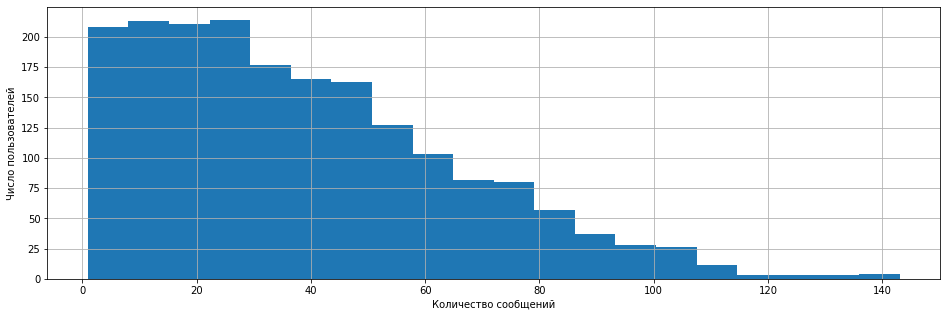

In [83]:
# построение гистограммы
df_smart['messages_per_month_count'].hist(bins=20, figsize=(16,5))
plt.pyplot.xlabel('Количество сообщений')
plt.pyplot.ylabel("Число пользователей")

График похож на распределение Пуассона.
Мы видим, что выборка смещена влево. Значит, большинство пользователей отправляет не так много сообщений. Однако есть и те, кто много переплачивает. 

Посчитаем, сколько сообщений в месяц понадобится, чтобы хватило практически всем. Применим правило трёх сигм.

In [76]:
# среднее + 3 стандартных отклонения
df_smart['messages_per_month_count'].mean() + 3*np.std(df_smart['messages_per_month_count'], ddof=1)

119.19864149994898

#### Звонки

Посмотрим на среднее, дисперсию и стандартное отклонение

In [77]:
# применение функции count_parameters для нужного столбца
count_parameters(df_smart['calls_per_month_duration'])

Среднее равно 397.86109660574414
Дисперсия равна 31529.85948364532
Стандартное отклонение равно 177.56649313326352


Посмотрим на гистограмму

Text(0, 0.5, 'Число пользователей')

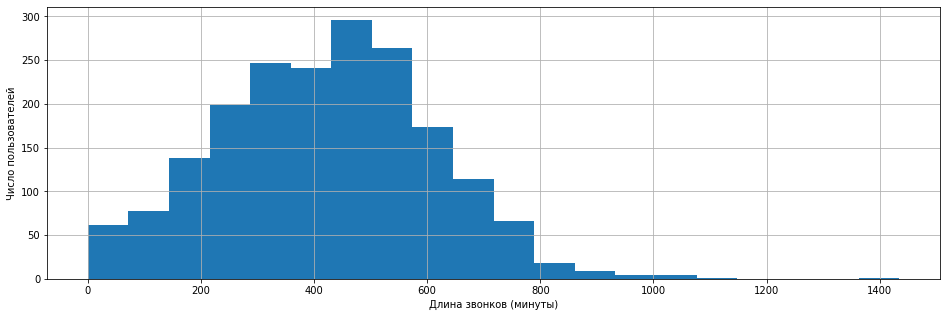

In [85]:
# построение гистограммы
df_smart['calls_per_month_duration'].hist(bins=20, figsize=(16,5))
plt.pyplot.xlabel('Длина звонков (минуты)')
plt.pyplot.ylabel("Число пользователей")

График похож на нормальное распределение

Посчитаем, сколько минут в месяц понадобится, чтобы хватило практически всем. Применим правило трёх сигм

In [79]:
# среднее + 3 стандартных отклонения
df_smart['calls_per_month_duration'].mean() + 3*np.std(df_smart['calls_per_month_duration'], ddof=1)

930.5605760055347

#### Трафик

Посмотрим на среднее, дисперсию и стандартное отклонение

In [80]:
# применение функции count_parameters для нужного столбца
count_parameters(df_smart['gb_per_month_sum'])

Среднее равно 16.362924281984334
Дисперсия равна 32.1634104618714
Стандартное отклонение равно 5.671279437822774


Посмотрим на гистограмму

Text(0, 0.5, 'Число пользователей')

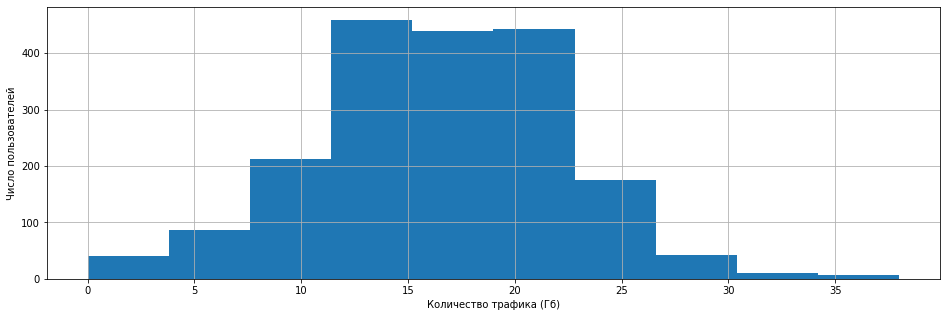

In [86]:
# построение гистограммы
df_smart['gb_per_month_sum'].hist(bins=10, figsize=(16,5))
plt.pyplot.xlabel('Количество трафика (Гб)')
plt.pyplot.ylabel("Число пользователей")

График напоминает нормальное распределение

Посчитаем, сколько трафика в месяц понадобится, чтобы хватило практически всем. Применим правило трёх сигм

In [82]:
# среднее + 3 стандартных отклонения
df_smart['gb_per_month_sum'].mean() + 3*np.std(df_smart['gb_per_month_sum'], ddof=1)

33.376762595452654

#### Выручка

Посмотрим на среднее, дисперсию и стандартное отклонение

In [83]:
# применение функции count_parameters для нужного столбца
count_parameters(df_smart['revenue'])

Среднее равно 1257.5099164490844
Дисперсия равна 647847.3258059463
Стандартное отклонение равно 804.8896357923527


Итак, по тарифу Смарт:
 * В среднем клиенты используют
     * 39 сообщений
     * 398 минут звонков
     * 16 Гб
 * Значения, чтобы тариф подошёл практически всем пользователям без переплат
    * 119 сообщений
    * 930 минут звонков
    * 33 Гб

Мы видим, что клиенты довольно часто переплачивают по тарифу

### Тариф ультра

#### Сообщения

Посмотрим на среднее, дисперсию и стандартное отклонение

In [84]:
# применение функции count_parameters для нужного столбца
count_parameters(df_ultra['messages_per_month_count'])

Среднее равно 61.640957446808514
Дисперсия равна 2008.5500113324103
Стандартное отклонение равно 44.81684963640807


Посмотрим на гистограмму

Text(0, 0.5, 'Число пользователей')

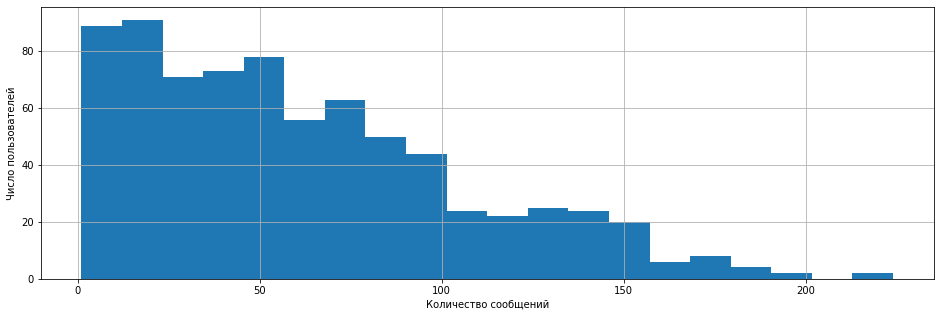

In [87]:
# построение гистограммы
df_ultra['messages_per_month_count'].hist(bins=20, figsize=(16,5))
plt.pyplot.xlabel('Количество сообщений')
plt.pyplot.ylabel("Число пользователей")

График вновь похож на распределение Пуассона и скошен влево. Отметим так же, что димита в 1000 сообщений никто не достигает.

Посчитаем, сколько сообщений в месяц понадобится, чтобы хватило практически всем. Применим правило трёх сигм

In [86]:
# среднее + 3 стандартных отклонения
df_ultra['messages_per_month_count'].mean() + 3*np.std(df_ultra['messages_per_month_count'], ddof=1)

196.0915063560327

#### Звонки

Посмотрим на среднее, дисперсию и стандартное отклонение

In [87]:
# применение функции count_parameters для нужного столбца
count_parameters(df_ultra['calls_per_month_duration'])

Среднее равно 526.1595744680851
Дисперсия равна 86696.15293084402
Стандартное отклонение равно 294.44210454832034


Посмотрим на гистограмму

Text(0, 0.5, 'Число пользователей')

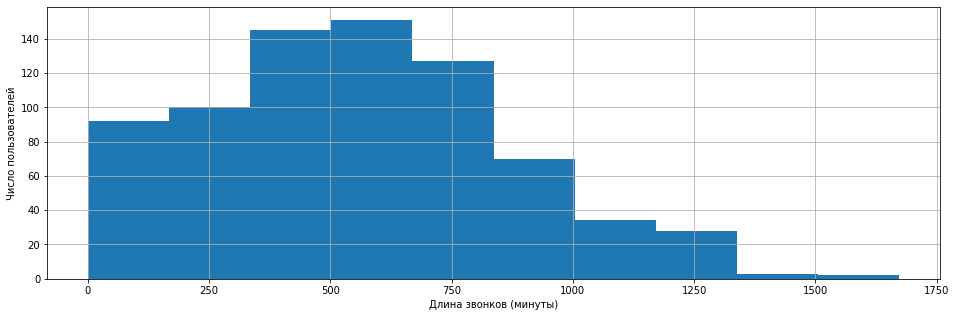

In [88]:
# построение гистограммы
df_ultra['calls_per_month_duration'].hist(bins=10, figsize=(16,5))
plt.pyplot.xlabel('Длина звонков (минуты)')
plt.pyplot.ylabel("Число пользователей")

График похож на нормальное распределение и скошен влево. Опять же лимита в 3000 минут не достигает никто

Посчитаем, сколько минут разговора в месяц понадобится, чтобы хватило практически всем. Применим правило трёх сигм

In [89]:
# среднее + 3 стандартных отклонения
df_ultra['calls_per_month_duration'].mean() + 3*np.std(df_ultra['calls_per_month_duration'], ddof=1)

1409.4858881130463

#### Трафик

Посмотрим на среднее, дисперсию и стандартное отклонение

In [90]:
# применение функции count_parameters для нужного столбца
count_parameters(df_ultra['gb_per_month_sum'])

Среднее равно 19.618351063829788
Дисперсия равна 88.13244574609722
Стандартное отклонение равно 9.387888247422698


Посмотрим на гистограмму

Text(0, 0.5, 'Число пользователей')

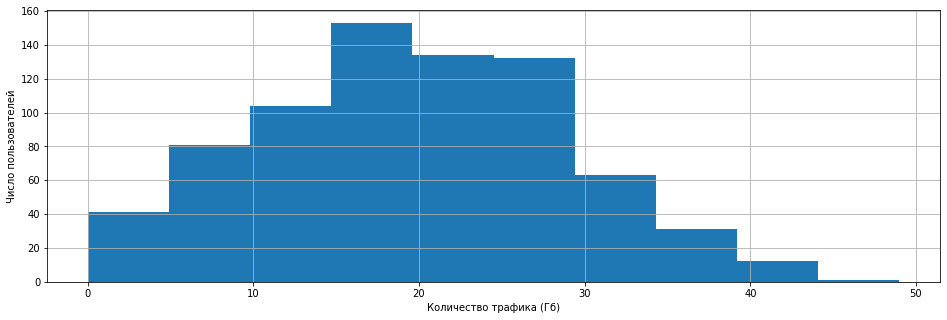

In [89]:
# построение гистограммы
df_ultra['gb_per_month_sum'].hist(bins=10, figsize=(16,5))
plt.pyplot.xlabel('Количество трафика (Гб)')
plt.pyplot.ylabel("Число пользователей")

График представляет собой скошенное вправо нормальное распределение. Здесь есть пользователи переплачивающие за трафик, но их не так много

Посчитаем, сколько трафика в месяц понадобится, чтобы хватило практически всем. Применим правило трёх сигм

In [92]:
# среднее + 3 стандартных отклонения
df_ultra['gb_per_month_sum'].mean() + 3*np.std(df_ultra['gb_per_month_sum'], ddof=1)

47.78201580609788

#### Выручка

Посмотрим на среднее, дисперсию и стандартное отклонение

In [93]:
# применение функции count_parameters для нужного столбца
count_parameters(df_ultra['revenue'])

Среднее равно 2048.936170212766
Дисперсия равна 110817.77488171868
Стандартное отклонение равно 332.89303819953744


Итак, по тарифу Ультра:
 * В среднем клиенты используют
     * 62 сообщения
     * 526 минут звонков
     * 19,6 ГБ
 * Значения, чтобы тариф подошёл практически всем пользователям без переплат
    * 196 сообщений
    * 1409 минут звонков
    * 48 Гб

Пользователи переплачивают только за трафик

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
     
 * Пользователи тарифа Смарт используют меньшее количество минут звонков и сообщений в месяц, чем пользователи Ультра. 
Однако, они сильнее переплачивают за услуги. реди пользователей тарифа Ультра никто не достигает лимита на звонки и сообщения. Так же видно, что пользователи тарифа Ультра тратят больше трафика. Скорее всего, именно он является важным фактором при выборе тарифа.   
 * Количество сообщений похоже на распределение Пуассона. Количество минут и трафик напоминают нормальное распределение

## Проверка гипотез

Проверим гипотезы:
 * средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
 * средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### Выручка пользователей разных тарифов различается

* Гипотеза H0: Средняя выручка от пользователей тарифа "Смарт" и тарифа "Ультра" одинаковая 
* Гипотеза H1: Выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается

(Гипотезы сформулированы именно так, поскольку нулевая гипотеза - всегда гипотеза об отстуствии различий. А альтернативная гипотеза двусторонняя, поскольку мы не можем точно утверждать, хотим ли мы проверить, что от пользователей "Смарт" вручка больше, чем от пользователей "Ультра" или наоборот)

Зададим критический уровень статистической значимости в 5%. Это довольно распространённое число, брать меньше него для нашей задачи не обязательно.

In [94]:
# зададим критический уровень статистической значимости в 5%
alpha = 0.05 

In [95]:
results = st.ttest_ind(
    df_smart['revenue'],
    df_ultra['revenue']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя тарифа smart:', df_smart['revenue'].mean())
print('Средняя выручка в месяц с пользователя тарифа ultra:', df_ultra['revenue'].mean())

p-значение: 6.539474517731644e-134
Отвергаем нулевую гипотезу

Средняя выручка в месяц с пользователя тарифа smart: 1257.5099164490844
Средняя выручка в месяц с пользователя тарифа ultra: 2048.936170212766


Можем отвергнуть нулевую гипотезу, выручка от пользователей тарифа "Смарт" и тарифа "Ультра" различается.
Мы видим, что среднее значение выручки пользователей тарифа Ультра больше.

### Выручка пользователей из Москвы и других регионов

 * Гипотеза H0: Средняя выручка от пользователей Москвы и регионов одинаковая
 * Гипотеза H1: Средняя выручка от пользователей Москвы и регионов различается

Выделим отдельно пользователей из Москвы и не из нее

In [97]:
# создание двух датафреймов, в зависимости от города пользователя (Москва, не Москва)
df_from_moscow = df_monthly_revenue.query('city == "Москва"')
df_not_from_moscow = df_monthly_revenue.query('city != "Москва"')

In [98]:
results = st.ttest_ind(
    df_from_moscow['revenue'],
    df_not_from_moscow['revenue']
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print()    
print('Средняя выручка в месяц с пользователя из Москвы',  df_from_moscow['revenue'].mean())
print('Средняя выручка в месяц с пользователя не из Москвы', df_not_from_moscow['revenue'].mean())

p-значение: 0.08193733674056428
Не получилось отвергнуть нулевую гипотезу

Средняя выручка в месяц с пользователя из Москвы 1536.6429124236258
Средняя выручка в месяц с пользователя не из Москвы 1468.0330055147042


Нулевую гипотезу отвергнуть не удалось - выручка с пользователей из Москвы и пользователей из других регионов почти равнозначна.

<div style="border:solid blue 2px; padding: 20px">

**Выводы**
    
Были проверены две гипотезы и получены следующие результаты:
 * Средняя выручка пользователей тарифов Ультра и Смарт различается. От пользователей тарифа Ультра она больше.
 * Средняя выручка пользователей из Москвы не отличается значимо от выручки пользователей из других регионов

## Общий вывод

Итак, в ходе подготовки данных мы:
 * Привели данные к нужным типам
 * Собрали необхлдимые данные в один датафрейм для исследования
 * Рассчитали необходимые значения выручки в месяц
 * Расформировали наш датасет в зависимости от тарифа

Выводы:  
* Пользователи тарифа Смарт используют чуть меньшее количество минут звонков и сообщений в месяц, чем пользователи Ультра
* Среди пользователей тарифа Ультра никто не достигает лимита на количество минут звонков и сообщений. 
* Клиенты выбирают тариф Ультра скорее всего из-за трафика

Проверяя гипотезы, мы выяснили, что
  * Выручка больше от пользователей тарифа Ультра
  * Выручка значимо не различается в зависимости от города (Москва/не Москва)
  
Общие выводы:
  * В целом, исходя из исследования можно сказать, что тариф Ультра приносит больше денег. Нужно продвигать его, причём как в Москве, так и в других регионах. Но пользователи тарифа Смарт часто  переплачивают за услуги, что тоже приносит дополнительные деньги. 
  * Можно отметить, что тариф Ультра предлагает клиентам сильно больше, чем им нужно на самом деле, поэтому, можно попробовать изменить условия тарифа, чтобы пользователям тарифа Смарт это предложение не казалось таким далёким от них, в результате чео они бы перешли на тариф Ультра и доходы бы увеличились. Однако, это может быть темой следующего исследования